# Кредитный скоринг

В задаче кредитного скоринга чаще всего применяется логистическа регрессия, как алгоритм извлечения зависимости.  
Из-за линейности модели важным является отбор и преобразования признаков.  
В данном ноутбуке мы рассмотрим несколько подходов к преобразования признаков.

---
# Загружаем выборку с данными

Выборка содержит заявки на кредит и поля:
* `application_date` - дата обработки заявки
* `default_flg` - факт наличия дефолта
* `f*, v*, d*` - признаки заявки

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

url_data = 'https://www.dropbox.com/s/vs9daqt83j8kfqf/feature_transformation.csv?dl=1'
df = pd.read_csv(url_data, parse_dates=['application_date'])
df.head()

,default_flg,application_date,f1,f2,f3,f4,v1,v2,v3,d1,d2
0,0,2015-10-27,2.0,49.0,60000.00,0.551720,1219.487337,21766.081065,2.0,0.047946,0.000000
1,1,2015-11-09,2.0,50.0,59365.20,0.379425,740.270898,11276.991322,2.0,-0.210390,0.377392
2,0,2015-05-07,2.0,18.0,43764.35,-0.260096,539.627752,11974.353651,0.0,-0.176838,0.426828
3,0,2015-11-15,2.0,60.0,60000.00,-0.522040,1046.368464,11772.704811,2.0,-0.213644,0.340425
4,0,2015-03-16,2.0,18.0,41637.74,0.179889,786.084579,14096.999560,2.0,-0.230048,0.472925


Мы будем извлекать зависимость между признаками и целевой переменной.   
Для валидации модели необходимо разбить выборку на две части по дате обработки заявки:
* обучающая выборка - заявки с датой подачи заявки ранее '2015-08-01'
* тестовая выборка - заявки с датой подачи начиная с '2015-08-01'

**Задание 1. Разбейте выборку на две части и посчитайте количество объектов в каждой выборке**

In [2]:
features = ['f1','f2','f3','f4','v1','v2', 'v3','d1', 'd2']

X_train = df.query('application_date <= "2015-08-01"')[features]
y_train = df.query('application_date <= "2015-08-01"')['default_flg']
X_test = df.query('application_date > "2015-08-01"')[features]
y_test = df.query('application_date > "2015-08-01"')['default_flg']

assert len(X_train) == len(y_train) and len(X_test) == len(y_test)
print('Обучающая выборка: ', len(X_train))
print('Тестовая выборка : ', len(X_test))

Обучающая выборка:  29924
Тестовая выборка :  20076


---
# Подбор коэффициента регуляризации для логистической регресии

Для извлечения зависимости будем использовать [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) с l2 регуляризацией.  

**Задание 2.**  
    Переберите коэффициент регуляризации в интервале от $10^{-3}$ до $10^{3}$.  
    Постройте график зависимости качества AUC на тестовой выборке от коэфиициента регуляризации и найдите оптимальное значение.

AUC    0.615713
dtype: float64
Best C:  0.164519058775


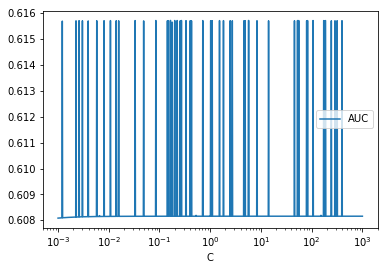

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

for C in np.logspace(-3, 3, num=1000):  # <изменить диапазон подбора коэффициента C>
    clf = LogisticRegression(C=C)   
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    metrics.loc[C] = auc
print(metrics.max())
C_best = metrics.AUC.idxmax()
print('Best C: ', C_best)
metrics.plot(logx=True);

---
# Нормализация признаков

Так как l2 регуляризация одинакого штрафует все признаки, то имеет смысл нормировать их все таким образом, чтобы стандартное отклонение равнялось 1 у всех признаков. Для этого можно воспользоваться [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Нормализовывать признаки стоит исходя из обучающей выборки, чтобы избегать переобучения.  
Для удобства трансформирования выборки В scikit-learn есть объекты [transformation](http://scikit-learn.org/stable/data_transforms.html), которые только преобразуют наборы признаков.  

Так же есть возможность объединять трансформации и модель в единый [пайплайн](http://scikit-learn.org/stable/modules/pipeline.html)
```python
classificator = make_pipeline(
    transformator_1,
  ...
    transformator_2,
    classifier
)
```

При обучении будут подряд обучаться и применятся трансформаторы transformator_1 ... transformator_k, а затем на полученных признаках обучаться модель.  
Данный подход удобен тем, что позволяет не изменять исходные выборки признаков и избежать ошибки с дублированием преобразований для обучающей и тестовой выборках.


**Задание 3.**  

  Произведите нормализацию признаков и опять подберите коэфиициент C.  
  Каким образом изменилось качество на тестовой выборке?  
  Запомните лучшее значение коэффициента регуляризации и затем используйте его.

AUC    0.700604
dtype: float64
Best C:  170.306502925


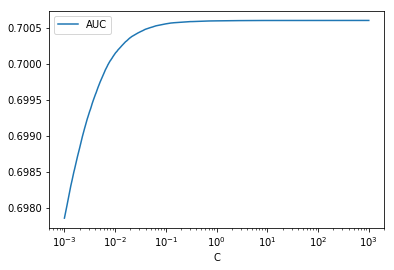

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# <вставить код>
# clf = make_pipeline(StandardScaler(), LogisticRegression(C=C))
metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

for C in np.logspace(-3, 3, num=1000):
    clf = make_pipeline(StandardScaler(), LogisticRegression(C=C))
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    metrics.loc[C] = auc
print(metrics.max())
C_best = metrics.AUC.idxmax()
print('Best C: ', C_best)
metrics.plot(logx=True);

---
# Нормализация WoE

Влияние некоторых признаков на целевую переменную может быть нелинейным с точки зрения WoE.  
Поэтому имеет смысл преобразовать признаки таким образом, чтобы зависимость стала линейной.

**Задание 4.**  
  Преобразуйте часть признаков таким образом, чтобы график зависимости WoE стал более линейным.  
  Посчитайте качество логистической регрессии после такой нормализации.

In [5]:
from scipy.special import logit

def woe_line(feature, target, num_bucket=20):
    """Подсчет зависимости WoE от среднего значения признака в бакете"""
    
    data = pd.DataFrame({'target': target, 'feature': feature})
    data['bucket'] = pd.qcut(feature, q=num_bucket, duplicates='drop')
    data['obj_count'] = 1
    
    target_mean = data['target'].mean()
    total_count = data['obj_count'].sum()
    
    data_agg = data.groupby('bucket').agg({'target': 'mean', 'feature': 'mean', 'obj_count': 'sum'})
    
    data_agg['target'] = np.clip(data_agg['target'], 0.001, 0.999)
    data_agg['woe'] = logit(data_agg['target']) - logit(target_mean)
    
    return data_agg[['feature', 'woe']]

In [6]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):    
    return np.log(x / (1 - x))

def feature_modification(X):
    """Функция модифицирования признаков"""
    X = pd.DataFrame(X, columns=X_train.columns).copy()
    
    # <вставить код с модификацией признаков>
    # Пример преобразования
    X['v1'] = np.log(X['v1'])
    X['v2'] = np.log(np.log(X['v2']))
    X['v3'] = -(X['v3'] - 1.5) ** 2
    X['d1'] = (X['d1'] + 2) ** 2
    
    # polynomial features
    
    #X['v12'] = X['v1'] * X['v2']
    #X['v1f1'] = X['v1'] * X['f1']
    #X['v2f4'] = X['v2'] * X['f4']
    
    #X['f1f2'] = X['f1'] * X['f2']
    #X['f1f3'] = X['f1'] * X['f3']
    #X['f2f3'] = X['f2'] * X['f3']
    #X['f4f3'] = X['f4'] * X['f3']
    
    #added = ['v12','v1f1','v2f4','f1f2','f1f3','f1f3', 'f1f3','f2f3', 'f4f3']

    # need one-hot encoding -_- but not today
    return X


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

clf = make_pipeline(
    FunctionTransformer(feature_modification),
    StandardScaler(),
    LogisticRegression(C=C_best)
)
    
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print(auc)

0.711689687193


f1:


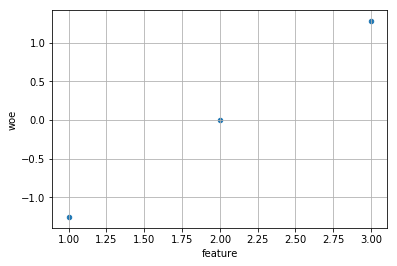

f2:


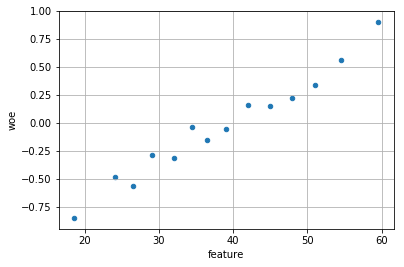

f3:


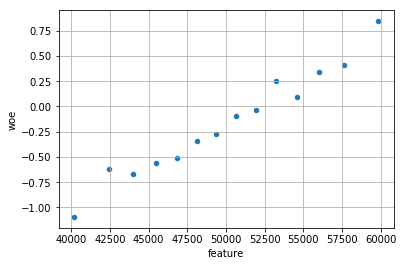

f4:


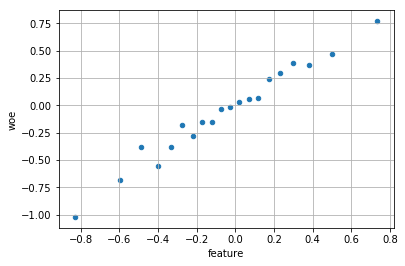

v1:


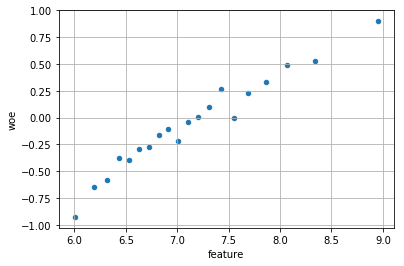

v2:


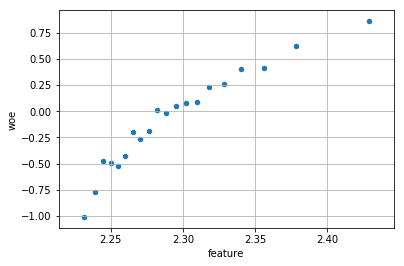

v3:


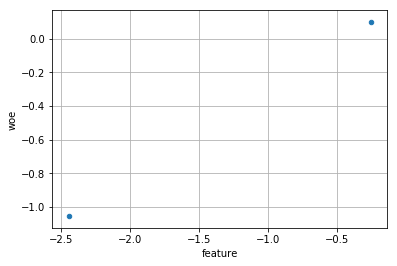

d1:


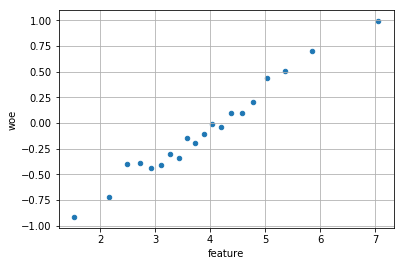

d2:


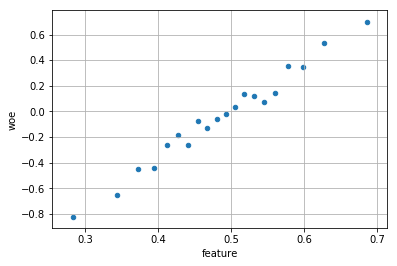

In [7]:
import matplotlib.pyplot as plt
X = feature_modification(X_train)
for feature in features:
    print(feature + ':')
    woe_line(X[feature], y_train).plot(kind='scatter', x='feature', y='woe', grid=True);
    plt.show()

Видим что почти все признаки лежат на прямой - достигли успеха.

---
# Стабильность признаков

Так как мы используем валидацию по времени, то некоторые признаки могут оказаться нестабильными и сильно изменять свое распределение.  
Иногда исключение данных признаков из обучения положительно сказывается на качестве модели на отложенной выборке.

**Задание 5.**  
  Произвести анализ стабильности распределений признаков по времени. Попытаться выделить нестабильные признаки.  
  Посчитать качество модели с исключенными нестабильными признаки.

In [8]:
def plot_distribution_stability(feature, date, num_buck=10, date_freq='M'):
    """Рисуем изменение распределения признака по времени"""
    df = pd.DataFrame({'feature': feature, 'date': date})
    df['feature_buck'] = pd.qcut(feature, q=num_buck, duplicates='drop')
    df_agg = df.groupby([pd.Grouper(key='date', freq=date_freq), 'feature_buck']).size().unstack()
    df_agg = df_agg.apply(lambda x: x / df_agg.sum(axis=1))
    df_agg.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1, 1))

f1:


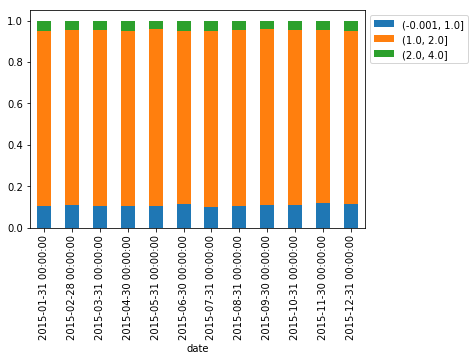

f2:


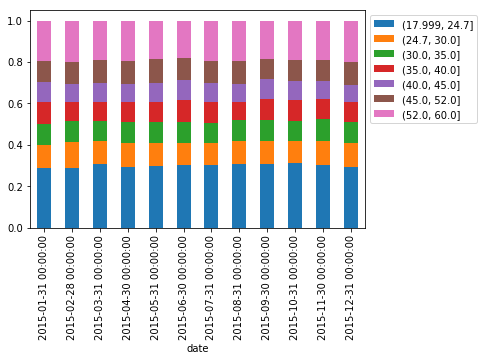

f3:


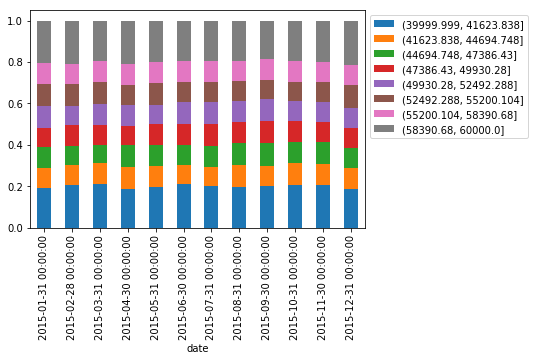

f4:


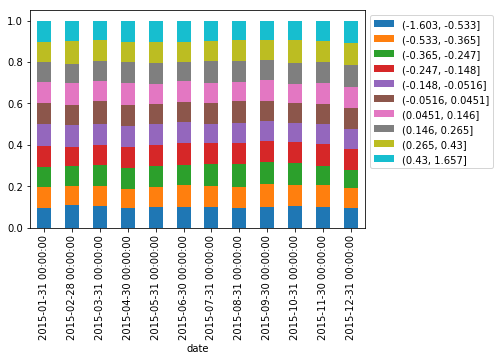

v1:


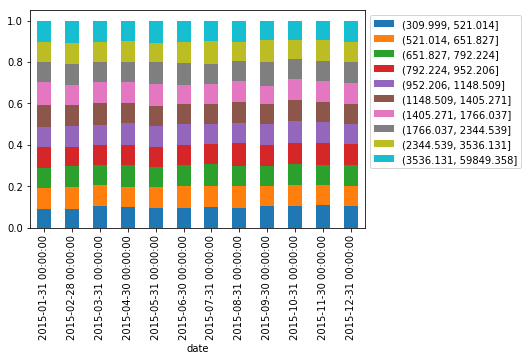

v2:


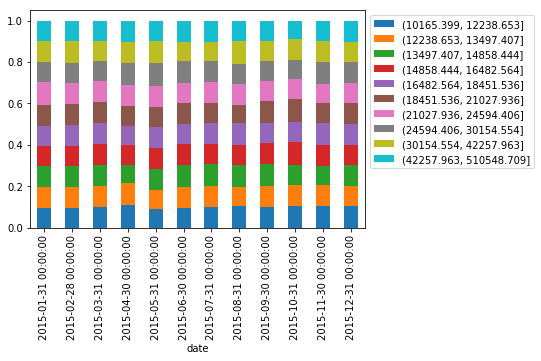

v3:


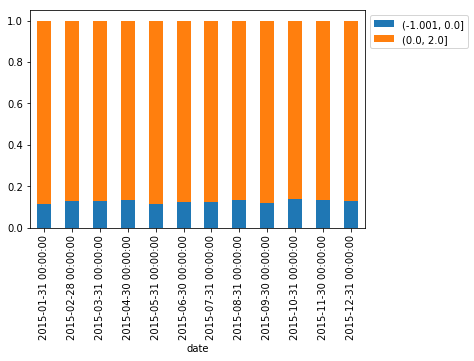

d1:


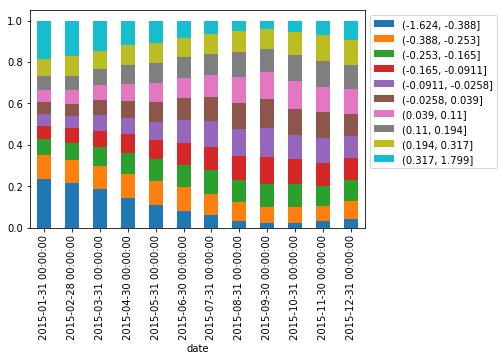

d2:


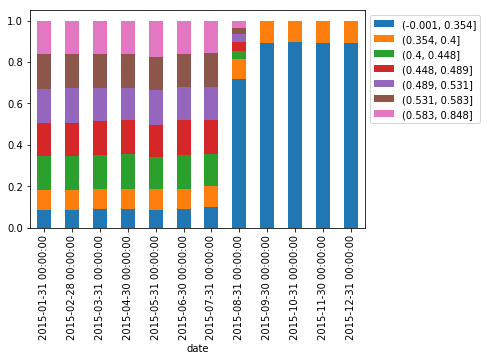

In [9]:
# Пример рисования изменения распределения у признака 'f1'
import matplotlib.pyplot as plt
for feature in features:
    print(feature + ':')
    plot_distribution_stability(df[feature], df['application_date'])
    plt.show()

In [10]:
def drop_features(X):
    """Функция отбрасывания части признаков"""
    X = pd.DataFrame(X, columns=X_train.columns)
    
    X = X.drop(columns=['d1'])
    X = X.drop(columns=['d2'])
    return X


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))


clf = make_pipeline(
    FunctionTransformer(feature_modification),
    FunctionTransformer(drop_features),
    StandardScaler(),
    LogisticRegression(C=C_best),
)
    
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print(auc)

0.735446649432


---
# Вывод

**Задание 6.**  
  Сравните результаты преобразования и отборов признаков по качеству. Какие методы и почему дали прирост в качестве?  
  Какие из них можно автоматизировать и каким образом? (В этом задании нужно только написать текст).

0. Нормализация действительно позволяет получить очень хороший прирост качества, что объясняется сутью самой регрессии - метода подбора коофициентов в линейной функции.
1. Удивительно хороший результат дала не столько линеаризация, сколько отброс всего лишнего. С другой стороны, поскольку мы ничего не знаем о происхождении признаков и их распределении, а так же не применяли one-hot encoding или Polinomial features(перемножает признаки формируя новые фичи) там где это было необходимо, то возможно лучший результат так и не был достигнут.
2. Наиболее просто оптимизировать применение нормализации и отброса признаков - если результат на тестовой выборке растет - применяем. (Хорошо бы проверять с помощью кросс-валидации, а не так как мы делали, конечно, поскольку вообще говоря можем и переобучиться)
3. Сложнее всего автoмaтизировать FunctionTransformer(feature_modification), так как кажется что именно человек хорошо умеет выбирать нужную нелинейность. С другой стороны, набор часто используемых нелинейностей ограничен (некоторые степени / log / exp / sigmoid) и можно для каждого признака перебрать их все выбрав лучшую на тестовой выборке, что правда долго реализуемо и не всегда хорошо будет работать.